# Introduction
In this notebook, we show an implementation of the Adjoint method used for the PDE discovery task. This code is used to produce the results in the manuscript titled 'Data-Driven Discovery of PDEs via the Adjoint Method', see https://arxiv.org/abs/2401.17177.

In [1]:
## Load necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import time
size = 6
cm = 0.393701

In order to execute cells with PDE-FIND method, please download/clone the PDE-FIND source code from

https://github.com/snagcliffs/PDE-FIND

in the directory that you are exectuing this jupyter notebook.

# Implementation of adjoint optimization

Here, we deploy finite difference to solve the PDE

\begin{flalign}
     \mathcal{L}_i[ \boldsymbol f]:= \partial_t f_i + \sum_{\boldsymbol d, \boldsymbol p} \alpha_{i, \boldsymbol d,\boldsymbol p}
     \nabla^{(\boldsymbol d)}_{{\boldsymbol x}} [ \boldsymbol f^{\boldsymbol p} ]=0
\end{flalign}

in $\texttt{forward\_m}$ and the adjoint equation
\begin{flalign}
    \frac{\partial \lambda_i}{\partial t} = \sum_{\boldsymbol d, \boldsymbol p} (-1)^{|\boldsymbol d|} \alpha_{i, \boldsymbol d,\boldsymbol p} \nabla_{f_i} [\boldsymbol f^{\boldsymbol p}]
\nabla^{(\boldsymbol d)}_{{\boldsymbol x}}[\lambda_i]
\end{flalign}

in $\texttt{adjoint\_eq}$. The training is done in $\texttt{AdjointFindPDE}$ where once $\boldsymbol f$ and $\boldsymbol \lambda$ are computed, then design paramters $\alpha$ are updated using the gradient of the objective function with respect to parameters
\begin{flalign}
    \frac{\partial \mathcal{C}}{\partial \alpha_{i, \boldsymbol d, \boldsymbol p}} = (-1)^{|\boldsymbol d|} \frac{1}{\Delta \boldsymbol x \Delta t} \int  \boldsymbol f^{\boldsymbol p}\, \nabla^{(\boldsymbol d)}_{{\boldsymbol x}}[\lambda_i] d\boldsymbol x dt + 2 \epsilon_0 \alpha_{i, \boldsymbol d, \boldsymbol p}~.
\end{flalign}

In [11]:
# Forward model with an expansion of all possible terms
def forward_m(params, ps, ds, f0, dx, dt, Nt):
    ## Inputs:
    #  params (numPDE, len(ds), P)
    #  ps is a list of powers for f
    #  e.g. [(0,0), (1,0), (2,1)] is 1, f_0, f_0^2*f_1
    #  ds is a list of derivative index tuples.
    #  e.g. [(0,0), (1,0), (2,0)] for f, df/dx0, d^2f/dx0^2
    #  f0 (numPDE, Nx1, Nx2, ...)
    #  dx (dx0, dx1, ...)
    ## Output:
    #  f (numPDE, Nt, Nx1, Nx2, ...)
    numPDE = f0.shape[0]
    grid_shape = f0[0,:].shape
    f = np.zeros( (numPDE,) + (Nt,) + grid_shape )
    f[:,0,:] = f0
    for i in range(Nt-1):
        f[:,i+1,:] = f[:,i,:]
        for i_pde in range(numPDE):
            for i_p, p in enumerate(ps):
                for i_d, d in enumerate(ds): ## for each d of ds, compute nabla^{d} [f^p] contribution
                    temp = np.ones_like(f[0, i, :])
                    for i_pi, pi in enumerate(p):
                        temp *= f[i_pi, i, :] ** pi
                    for i_di, di in enumerate(d): ## for each element di of d=(d0,d1,...)
                        for _ in range(1, di+1): ## take di derivatives
                            temp = np.gradient(temp, axis=i_di)/dx[i_di]
                    # multiply to its parameter, then add to the whole expression
                    f[i_pde, i+1,:] -= params[i_pde, i_d, i_p] * temp * dt
    return f

# Adjoint equation for the Lagarange multiplier
def adjoint_eq(params, P, ds, fs, f, dx, dt, Nt):
    ## Inputs:
    #  params (numPDE, len(ds), P)
    #  ps is a list of powers for f
    #  e.g. [(0,0), (1,0), (2,1)] is 1, f_0, f_0^2*f_1
    #  ds is a list of derivative index tuples.
    #  e.g. [(0,0), (1,0), (2,0)] for f, df/dx1, d^2f/dx^2
    #  fs (numPDE, Nx1, Nx2, ...)
    #  f (numPDE, Nt, Nx1, Nx2, ...)
    #  dx (dx0, dx1, ...)
    ## Output:
    #  lam (numPDE, Nt, Nx0, Nx1, ...)
    numPDE = f.shape[0]
    lam = np.zeros(f.shape)
    lam[:, -1, :] = 2 * (fs[:, :] - f[:, -1, :])
    for i in range(Nt - 1, 0, -1):
        lam[:, i-1, :] = lam[:, i, :] #+ 1e-10*f[:, i,:] * dt  #+ 2 * (fs[:, i, :] - f[:, i,:]) * dt
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):## for each d of ds, compute nabla^{d}[lambda] contribution
                temp = lam[i_pde, i, :]
                for i_di, di in enumerate(d): ## for each element di of d=(d0,d1,...)
                    for _ in range(1, di+1):
                        temp = np.gradient(temp, axis=i_di)/dx[i_di]
                temp *= (-1)**(sum(d))
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(f[0, i, :])
                    for i_pi, pi in enumerate(p):
                        if i_pi != i_pde:
                            tempf *= f[i_pi, i, :] ** pi
                        else:
                            if pi>0: # take derivative if f_i has power > 0
                                tempf *= pi *  f[i_pi, i, :] ** (pi-1)
                            else:
                                tempf *= 0. ## set derivative to zero when f^p does not have any term with f_i
                    lam[i_pde, i-1,:] -= params[i_pde, i_d, i_p] * tempf * temp * dt
    return lam

# Finding the parameters of the PDE using adjoint method
def AdjointFindPDE(fs, dx, data_dt=1, Nt_fine=2, nt=None, dt=None, avg=False, gamma=1e-3, epochs=100, epthr=50, beta = 0.01, learning_rates=None, ds=np.array([[1], [2], [3]]), ps=np.array([[1], [2], [3]]), V = 1., tol = 1e-12, eps0=1e-12):
    if nt is None:
        nt = [Nt_fine for _ in range(fs.shape[1])]
        dt = [data_dt/(Nt_fine-1) for _ in range(fs.shape[1])]
    numPDE = fs.shape[0]
    D = np.max(np.sum(ds,axis=1))
    P = np.max(np.sum(ps,axis=1))
    params = np.zeros((numPDE,len(ds),len(ps)))
    if learning_rates is None:
        learning_rates = np.ones((numPDE, len(ds),len(ps)))
        for i, d in enumerate(ds):
            for j, p in enumerate(ps):
                learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) )
    estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
    estimated_params[0,:] = params

    params0 = params
    for ep in range(1, epochs+1):
        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i in range(len(nt)-1):
            fst = fs[:, i:i+2,:]
            ft0 = fst[:, 0, :]
    
            ft  = forward_m(params, ps, ds, ft0, dx, dt[i], nt[i])
            
            lam = adjoint_eq(params, ps, ds, fst[:, -1,:], ft, dx, dt[i], nt[i])

            if avg is False:
                dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
            for i_pde in range(numPDE):
                for i_d, d in enumerate(ds):
                    temp = np.array([lam[i_pde, ii,:] for ii in range(nt[i])])
                    for i_di, di in enumerate(d):
                        for rep in range(1, di+1):
                            temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(nt[i])] ) / dx[i_di]
                    temp *= (-1)**sum(d)
                    for i_p, p in enumerate(ps):
                        tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                        for i_pi, pi in enumerate(p):
                            tempf *= ft[i_pi, :]**pi
                        integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(nt[i])] )
                        for xi in range(len(dx)-1, -1, -1):
                            integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(nt[i])] )
                        dC_dparams[i_pde, i_d, i_p] += np.sum(integ) * dt[i] / (nt[i]*dt[i]) / V + 2*eps0*params[i_pde, i_d, i_p]
            if avg is False:
                # update parameters afte seeing each data points
                params = params - dC_dparams * learning_rates
            if ep>epthr: # thresholding
                params[abs(params)<gamma] = 0.
        if avg is True:
            # update parameters only after seeing all the data points
            params = params - dC_dparams/len(nt) * learning_rates
        if ep>epthr:# thresholding
            params[abs(params)<gamma] = 0.
        estimated_params[ep,:] = params
        if np.linalg.norm(params-params0) < tol:
            epochs = ep
            break
        params0 = params
    
    estimated_params = estimated_params[:epochs,:]
    eps = [i for i in range(epochs)]
    return estimated_params, eps
    

# Examples
Here, we show how the proposed adjoint method can recover the underlying PDE given data in several examples. 

## Heat Equation

Let us consider measured data collected from the solution to the heat equation, i.e.
\begin{flalign}
    \frac{\partial f}{\partial t} + D \,\frac{\partial^2 f}{\partial x^2} = 0,
\end{flalign}
with $D = -1$. The data is constructed using the Finite Difference method with initial condition $f(x, 0) = 5\sin(2 \pi x)x(x-L)$ and a mesh with $N_x=100$ nodes in $x$ covering the domain $\Omega = [0,L]$ with $L=1$ and $N_t=100$ steps in $t$ with final time $T=N_t \Delta t$ where $\Delta t = 0.05 \Delta x^2/(1+|D|)$ is the step size and $\Delta x=L/N_x$ is the mesh size in $x$.

### Generate Data

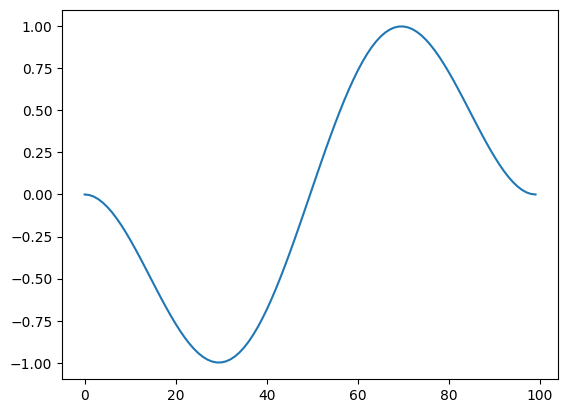

In [94]:
## generate data
# df/dt + D d2f/dx^2 = 0

CFL = 0.05
def dt_cfl(dx, D_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx**2/(1.+abs(D_m))
    
def heat_equation(D_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - D_m * np.gradient(np.gradient(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
D_ex = -1.0  # Thermal diffusivity

dx = L/Nx
dt = dt_cfl(dx, D_ex)
Nt = 100
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = heat_equation(D_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

plt.plot(fs[0,0,:])

fs0 = fs.copy()

### PDE discovery using Adjoint method

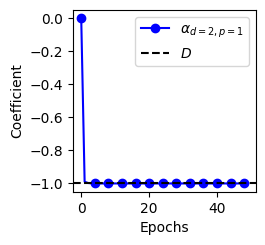

Execution time: 6.388177871704102
total number of terms: 9
3.700910285618246e-12


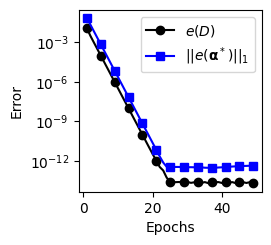

In [95]:
start_time = time.time()

problem = "1D_heat_equation"
numPDE = fs.shape[0]

ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

estimated_params, eps = AdjointFindPDE(fs, dx, data_dt=dt, Nt_fine=2, avg=False, gamma=1e-3, epochs=50, epthr=50, beta = 0.1, ds=ds, ps=ps, V = L, tol = 1e-15, eps0=1e-16)

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==2 and p[0]==1 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
            err_D = estimated_params[-1,i_pde,id,ip]
err_D = abs(err_D - D_ex)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Dconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==2 and p[0]==1 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "D"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))
print((err_other[-1])+err_D)


### PDE discovery using PDE-FIND

In [96]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,0.1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(coeff_pdefind[0])
print(np.sum(coeff_pdefind[1:]) + abs(-coeff_pdefind[0]-D_ex))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (1.000000 +0.000000i)u_{xx}
   
Execution time: 1.1539630889892578
[1.]
[2.91719982e-10]


## Burgers' equation

As a nonlinear test case, let us consider the data from Burgers' equation given by
\begin{flalign}
    \frac{\partial f}{\partial t} + \frac{\partial (A f^2)}{\partial x} = 0
\end{flalign}
where $A = -1$. The data is obtained with similar simulation setup as for heat equation except for the time step, i.e. $\Delta t = 0.05 \Delta x/(1+|A|)$.

### Generate Data

(1, 100)
(1, 100)
(1, 1000, 100)


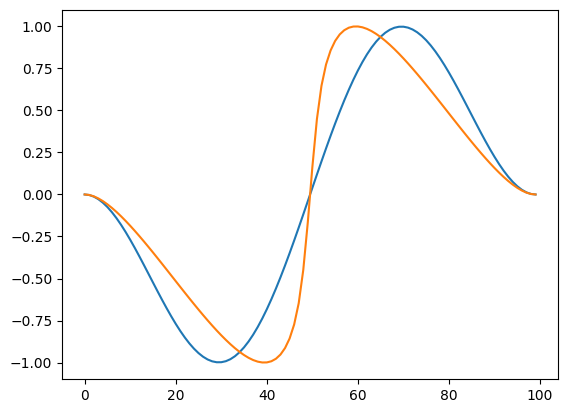

In [97]:
## generate data
# df/dt + A*f*df/dx = 0

CFL = 0.01
def dt_cfl(dx, A_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx/(1.+abs(A_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def burger_equation(A_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - np.gradient( A_m*f_m[i,:]**2)/dx_m * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient

dx = L/Nx
dt = dt_cfl(dx, A_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = burger_equation(A_ex, f0, dx, dt, Nt)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

print(x.shape)
print(f0.shape)
print(fs.shape)
plt.plot(fs[0,0,:])
plt.plot(fs[0,-1,:])

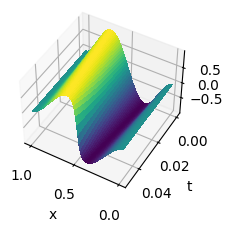

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ts = np.array([[i*dt for i in range(Nt)]])

X, T = np.meshgrid(x[0], ts[0])
fig = plt.figure(figsize=(size*cm, size*cm))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, fs[0,:,:], rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.view_init(elev=45, azim=120)
plt.xlabel('x')
plt.ylabel('t')
plt.savefig("data_BurgersEq"+".pdf",format='pdf', bbox_inches="tight", dpi=300)

### Discover PDE using adjoint method

Execution time: 67.67886114120483


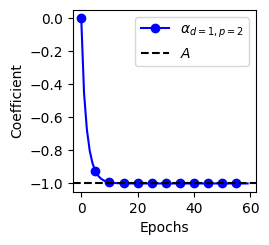

total number of terms: 9
8.754858773194209e-13


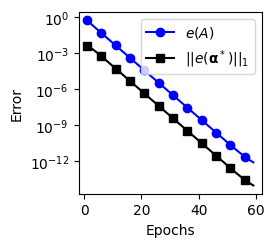

In [99]:
problem = "1D_burgers_eq"

ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, data_dt=dt, avg=False, gamma=1e-3, epochs=60, epthr=60, beta = 0.0001, ds=ds, ps=ps, V = L, tol = 1e-15, eps0=1e-16)
end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==1 and p[0]==2 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue",marker="o", markevery=5)
            total_error = estimated_params[-1,i_pde,id,ip]
total_error = abs(total_error-A_ex)
plt.axhline(A_ex, color="black", linestyle = "--", label=r"$A$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "Aconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==1 and p[0]==2 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker="o", markevery=5, color="blue")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=5, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "A"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

total_error += err_other[-1]
print(total_error)


### Discover PDE using PDE-FIND

In [100]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

fs = fs0.copy()

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))


for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (0.001245 +0.000000i)u_{xx}
    + (0.229404 +0.000000i)u^3
    + (2.021920 +0.000000i)uu_{x}
    + (0.003402 +0.000000i)u^2u_{xx}
    + (0.000074 +0.000000i)uu_{xxx}
   
Execution time: 14.072757005691528


## Kuramoto Sivashinsky Equation

As a more challenging test case, let us consider the recovery of the Kuramoto-Sivashinsky (KS) equation given by
\begin{flalign}
    \frac{\partial f}{\partial t} + A \frac{\partial f^2}{\partial x} + B \frac{\partial^2 f}{\partial x^2} + C\frac{\partial^4 f}{\partial x^4}= 0
\end{flalign}
where $A = -1$, $B = 0.5$ and 
$C = -0.5$. The data is generated similar to previous sections except for the grid $(N_t,N_x)=(64,256)$ and the time step size $\Delta t = 0.01 \Delta x^4/(1+|C|)$.

### Generate Data

(1, 256)
(1, 256)
(1, 64, 256)


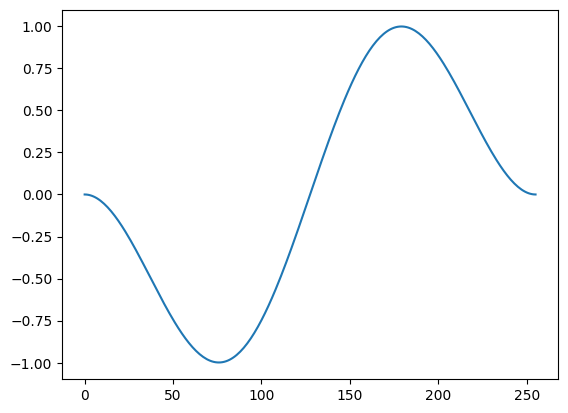

In [101]:
from numpy import gradient as grad
# ut + A*uxxxx + B*u*ux + D*uxx = 0
def dt_cfl(dx, C_m):
    # dt of simulation should be set satisfying CFL condition for stability
    CFL = 0.01
    return CFL*dx**4/(1.+abs(C_m))
    
def Kuramoto_Sivashinsky_equation(A_m, B_m, C_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:]
        f_m[i+1,:] += - C_m * grad(grad(grad(grad(f_m[i,:]))))/dx_m**4 * dt_m        
        f_m[i+1,:] += - A_m * grad(f_m[i,:]**2)/dx_m * dt_m 
        f_m[i+1,:] += - B_m * grad(grad(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 256  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient
B_ex = 0.5
C_ex = -0.5

dx = L/Nx
dt = dt_cfl(dx, C_ex)
Nt = 64
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = Kuramoto_Sivashinsky_equation(A_ex, B_ex, C_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

print(x.shape)
print(f0.shape)
print(fs.shape)
plt.plot(fs[0,0,:])

### Discover PDE using adjoint method

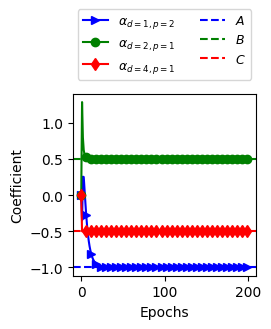

Execution time: 16.03332805633545
total number of terms: 8
4.760729865882496e-09


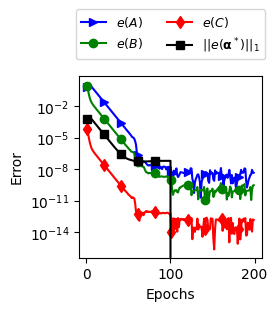

In [102]:
thresholding = True
problem = "Kuramoto_Sivashinsky_noise"
noise = 0.0/100. # added noise as standard deviation of the normal distribution
fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )

ds = np.array([[1], [2], [3], [4]])
ps = np.array([[1], [2]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, data_dt=dt, avg=False, gamma=1e-3, epochs=200, epthr=100, beta=50.0, ds=ds, ps=ps, V=L, tol=1e-15, eps0=1e-20)
end_time = time.time()

numPDE = fs.shape[0]
i_pde = 0
error = 0.

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            error += abs( estimated_params[-1,i_pde,id,ip]-A_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker=">", markevery=6)

for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            error += abs( estimated_params[-1,i_pde,id,ip]-B_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="green", marker="o", markevery=6)
            
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==4 and p[0]==1:
            error += abs( estimated_params[-1,i_pde,id,ip]-C_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="red", marker="d", markevery=6)

plt.axhline(A_ex, color="blue", linestyle = "--", label=r"$A$")
plt.axhline(B_ex, color="green", linestyle = "--", label=r"$B$")
plt.axhline(C_ex, color="red", linestyle = "--", label=r"$C$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=9)
name = problem + "_" + "coeffconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()


print("Execution time: "+str(end_time-start_time))

err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (  (d[0]==4 and p[0]==1) or
                  (d[0]==2 and p[0]==1) or
                  (d[0]==1 and p[0]==2)    ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker=">", markevery=20, color="blue")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-B_ex),
                     label=r"$e(B)$", marker="o", markevery=20, color="green")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==4 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-C_ex),
                     label=r"$e(C)$", marker="d", markevery=20, color="red")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=20, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=9)
name = problem + "_" + "coeff"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

error += err_other[-1]

print(error)


### Discover PDE using PDE-FIND

In [103]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))
uxxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3
    uxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0) / dx[0]**4

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))
uxxxx = uxxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx, uxxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'u', 'u^2', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'uu_{xxxx}', 'u^2u_{xxxx}']
u_t = (-0.500019 +0.000000i)u_{xx}
    + (0.500000 +0.000000i)u_{xxxx}
    + (0.042182 +0.000000i)u
    + (1.972311 +0.000000i)uu_{x}
    + (-0.001448 +0.000000i)u^2u_{xx}
    + (-0.000331 +0.000000i)uu_{xxx}
    + (-0.000021 +0.000000i)u^2u_{xxxx}
   
Execution time: 1.6387300491333008


## Reaction Diffusion Equation

In order to show scalability and accuracy of the adjoint method for a system of PDEs in a higher dimensional space, let us consider a system of PDEs given by
\begin{flalign}
    &\frac{\partial u}{\partial t} + c_0^u\nabla^2_{{x_1}}[u] + c_1^u\nabla^2_{{x_2}}[u] + R^u(u, v) = 0,\\
    &\frac{\partial v}{\partial t} + c_0^v\nabla^2_{{x_1}}[v] + c_1^v\nabla^2_{{x_2}}[v] + R^v(u, v) = 0
  \end{flalign}
  where
  \begin{flalign}
    R^u(u, v) &= c^u_2 u + c^u_3 u^3 + c^u_4  uv^2 + c^u_5  u^2v + c^u_6 v^3
    \\
    R^v(u, v) &= c^v_2 v + c^v_3 v^3 + c^v_4  vu^2 + c^v_5  v^2u + c^v_6 u^3
\end{flalign}

### Generate Data
We construct the data set by solving the system of PDEs using a 2nd order Finite Difference scheme with initial values
\begin{flalign}
    &u_0 = a \sin\left(\frac{4 \pi x_1}{L_1}\right)  \cos\left(\frac{3\pi x_2}{L_2}\right) \left(L_1x_1-x_1^2\right)  \left(L_2x_2-x_2^2\right)\\
    &v_0 =a \cos\left(\frac{4 \pi x_1}{L_1}\right)  \sin\left(\frac{3\pi x_2}{ L_2}\right)\left(L_1x_1-x_1^2\right)\left(L_2x_2-x_2^2\right)
\end{flalign}
where $a=100$, and the coefficients
\begin{flalign}
    &\boldsymbol c^u = [c^u_i]_{i=0}^6 = [-0.1, -0.2, -0.3, -0.4, 0.1, 0.2, 0.3]\\
    &\boldsymbol c^v = [c^v_i]_{i=0}^6 = [-0.4, -0.3, -0.2, -0.1, 0.3, 0.2, 0.1].
\end{flalign}
We generate data by solving the system of PDEs using the Finite Difference method and forward Euler scheme for $N_t=25$ steps with a time step size of $\Delta t=10^{-6}$, and in the domain $\Omega=[0,L_1]\times [0,L_2]$ where $L_1=L_2=1$ which is discretized using a uniform grid with $N_{x_1}\times N_{x_2}=50^2$ nodes leading to mesh size $\Delta x_1=\Delta x_2 = 0.02$.

In [104]:
## 2D, 2PDE Reaction_diffusion_equation

# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0

Nx0 = 50  # Number of grid points in x-direction
Nx1 = 50  # Number of grid points in y-direction
Lx0 = 1.0  # Domain size in x-direction
Lx1 = 1.0  # Domain size in y-direction
V = Lx0*Lx1
dt = 0.000001  # Time step size
Nt = 50

# Discretize the spatial domain
x0 = np.linspace(0, Lx0, Nx0)
x1 = np.linspace(0, Lx1, Nx1)
x = np.array([x0, x1])
dx0 = x0[1] - x0[0]
dx1 = x1[1] - x1[0]
X0, X1 = np.meshgrid(x0, x1)
dx = np.array([dx0, dx1])

# Set initial conditions
f0 = np.array([np.sin(4*np.pi*X0/Lx0) * np.cos(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100,
               np.cos(4*np.pi*X0/Lx0) * np.sin(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100])

def Reaction_diffusion_equation(coefu, coefv, u0_m, v0_m, dx_m, dy_m, dt_m, Nt_m):
    u_m = np.zeros((Nt_m, u0_m.shape[0], u0_m.shape[1]))# (Nt, Nx, Ny)
    v_m = np.zeros((Nt_m, v0_m.shape[0], v0_m.shape[1]))#
    u_m[0,:,:] = u0_m
    v_m[0,:,:] = v0_m
    for i in range(Nt_m-1):
        u_m[i+1,:,:] =  u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[0] * np.gradient( np.gradient(u_m[i,:,:],axis=0), axis=0) / dx_m**2 
        u_m[i+1,:,:] += - dt_m*coefu[1] * np.gradient( np.gradient(u_m[i,:,:],axis=1), axis=1) / dy_m**2
        u_m[i+1,:,:] += - dt_m*coefu[2] * u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[3] * u_m[i,:,:]**3
        u_m[i+1,:,:] += - dt_m*coefu[4] * u_m[i,:,:]    * v_m[i,:,:]**2
        u_m[i+1,:,:] += - dt_m*coefu[5] * u_m[i,:,:]**2 * v_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[6] * v_m[i,:,:]**3
        
        v_m[i+1,:,:] =  v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[0] * np.gradient( np.gradient(v_m[i,:,:],axis=0), axis=0) / dx_m**2 
        v_m[i+1,:,:] += - dt_m*coefv[1] * np.gradient( np.gradient(v_m[i,:,:],axis=1), axis=1) / dy_m**2
        v_m[i+1,:,:] += - dt_m*coefv[2] * v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[3] * v_m[i,:,:]**3
        v_m[i+1,:,:] += - dt_m*coefv[4] * v_m[i,:,:]    * u_m[i,:,:]**2
        v_m[i+1,:,:] += - dt_m*coefv[5] * v_m[i,:,:]**2 * u_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[6] * u_m[i,:,:]**3
    return u_m, v_m

coefu = [-0.1, -0.2, -0.3, -0.4, 0.1, 0.2, 0.3]
coefv = [-0.4, -0.3, -0.2, -0.1, 0.3, 0.2, 0.1]
coef = np.array([coefu, coefv])
# Generate data
fs0, fs1 = Reaction_diffusion_equation(coefu, coefv, f0[0,:], f0[1,:], dx0, dx1, dt, Nt)
fs = np.array([fs0, fs1])

### Discover PDE using adjoint method

total number of terms: 80
8.889200058668928e-09
Execution time: 372.8263478279114


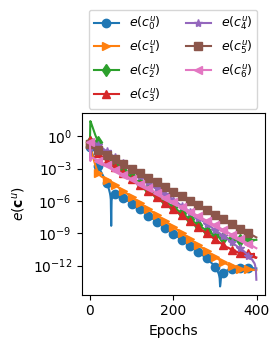

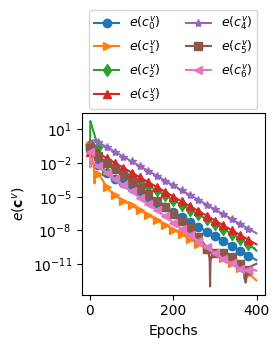

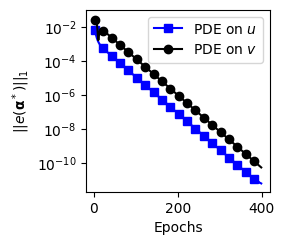

In [105]:
ds = np.array([[0,0], [1,0], [0,1], [2,0], [0,2]])
ps = np.array([[1,0], [0,1], [2,0], [0,2], [2,1], [1,2], [3,0], [0,3]])

beta = 0.004
D = 2
P = 3
numPDE = fs.shape[0]
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) ) *10**(P-sum(p))
        if sum(d) == 0:
            learning_rates[:,i,j] *= 70
            
start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, data_dt=dt, avg=False, gamma=1e-3, epochs=400, epthr=400, learning_rates=learning_rates, ds=ds, ps=ps, V=1, tol=1e-15, eps0=1e-16)
end_time = time.time()


# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0
problem = "2D_reaction"
## coeff of u
totalerror = 0
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[0]),#/abs(coefu[0]),
                     label=r"$e(c^u_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[1]),#/abs(coefu[1]),
                     label=r"$e(c^u_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[2]),#/abs(coefu[2]),
                     label=r"$e(c^u_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[3]),#/abs(coefu[3]),
                     label=r"$e(c^u_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[4]),#/abs(coefu[4]),
                     label=r"$e(c^u_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[5]),#/abs(coefu[5]),
                     label=r"$e(c^u_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[6]),#/abs(coefu[6]),
                     label=r"$e(c^u_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^u)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_u"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## other coeff of u
i_pde = 0


err_otheru = np.zeros_like(estimated_params[:,0,0,0])
countu = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==1 and p[1]==0)
                or (d[1]==2 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3) ) :
                    err_otheru += abs(estimated_params[:,i_pde,id,ip])
                    countu += 1

## coeff of v
i_pde = 1
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[0]),#/abs(coefv[0]),
                     label=r"$e(c^v_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[1]),#/abs(coefv[1]),
                     label=r"$e(c^v_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[2]),#/abs(coefv[2]),
                     label=r"$e(c^v_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[3]),#/abs(coefv[3]),
                     label=r"$e(c^v_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[4]),#/abs(coefv[4]),
                     label=r"$e(c^v_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[5]),#/abs(coefv[5]),
                     label=r"$e(c^v_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[6]),#/abs(coefv[6]),
                     label=r"$e(c^v_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^v)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_v"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

err_otherv = np.zeros_like(estimated_params[:,1,0,0])
countv = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==0 and p[1]==1)
                or (d[1]==2 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0) ) :
                    err_otherv += abs(estimated_params[:,i_pde,id,ip])
                    countv += 1
            

plt.figure(figsize=(size*cm, size*cm))

plt.plot(eps[2:], err_otheru[2:]/countu, marker="s", markevery=20, label=r"PDE on $u$", color="blue")
plt.plot(eps[2:], err_otherv[2:]/countv, marker="o", markevery=20, label=r"PDE on $v$", color="black")
plt.legend()
plt.yscale('log')
plt.ylabel(r'$||e(\mathbf{\alpha}^*)||_1$')
plt.xlabel('Epochs')
name = problem + "_" + "other_alphas"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

totalerror += err_otheru[-1]
totalerror += err_otherv[-1]
print(totalerror)

print("Execution time: "+str(end_time-start_time))


### Discover PDE using PDE-FIND

In [106]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1
num_points = Nx0*Nx1*nt

print(nt)
print(Nx0)
# Take up to second order derivatives.
u = np.zeros((nt, Nx0, Nx1))
v = np.zeros((nt, Nx0, Nx1))
ut = np.zeros((nt, Nx0, Nx1))
vt = np.zeros((nt, Nx0, Nx1))
ux = np.zeros((nt, Nx0, Nx1))
uy = np.zeros((nt, Nx0, Nx1))
uxx = np.zeros((nt, Nx0, Nx1))
uxy = np.zeros((nt, Nx0, Nx1))
uyy = np.zeros((nt, Nx0, Nx1))
vx = np.zeros((nt, Nx0, Nx1))
vy = np.zeros((nt, Nx0, Nx1))
vxx = np.zeros((nt, Nx0, Nx1))
vxy = np.zeros((nt, Nx0, Nx1))
vyy = np.zeros((nt, Nx0, Nx1))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    v[i,:] = fs[1, i, :]

    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    vt[i,:] = (fs[1, i+1, :]-fs[1, i, :])/dt
    
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uy[i,:] = np.gradient(u[i,:], axis=1) / dx[1]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uyy[i,:] = np.gradient( np.gradient(u[i,:],axis=1), axis=1) / dx[1]**2
    uxy[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=1) / dx[0]/ dx[1]

    vx[i,:] = np.gradient(v[i,:], axis=0) / dx[0]
    vy[i,:] = np.gradient(v[i,:], axis=1) / dx[1]
    vxx[i,:] = np.gradient( np.gradient(v[i,:],axis=0), axis=0) / dx[0]**2
    vyy[i,:] = np.gradient( np.gradient(v[i,:],axis=1), axis=1) / dx[1]**2
    vxy[i,:] = np.gradient( np.gradient(v[i,:],axis=0), axis=1) / dx[0]/ dx[1]

u = u.reshape((nt * Nx0 * Nx1, 1))
v = v.reshape((nt * Nx0 * Nx1, 1))

ut = ut.reshape((nt * Nx0 * Nx1, 1))
vt = vt.reshape((nt * Nx0 * Nx1, 1))

ux = ux.reshape((nt * Nx0 * Nx1, 1))
uy = uy.reshape((nt * Nx0 * Nx1, 1))
uxx = uxx.reshape((nt * Nx0 * Nx1, 1))
uyy = uyy.reshape((nt * Nx0 * Nx1, 1))
uxy = uxy.reshape((nt * Nx0 * Nx1, 1))

vx = vx.reshape((nt * Nx0 * Nx1, 1))
vy = vy.reshape((nt * Nx0 * Nx1, 1))
vxx = vxx.reshape((nt * Nx0 * Nx1, 1))
vyy = vyy.reshape((nt * Nx0 * Nx1, 1))
vxy = vxy.reshape((nt * Nx0 * Nx1, 1))

X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
print(['1'] + description[1:])

print("time: "+str(time.time()-start_time))

cu = TrainSTRidge(X,ut,5*10**-5,1)
print_pde(cu, description)

print("time: "+str(time.time()-start_time))

cv = TrainSTRidge(X,vt,5*10**-5,1)
print_pde(cv, description, ut = 'v_t')

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

49
50
['1', 'u_{x}', 'u_{y}', 'u_{xx}', 'u_{xy}', 'u_{yy}', 'v_{x}', 'v_{y}', 'v_{xx}', 'v_{xy}', 'v_{yy}', 'v', 'u', 'v^2', 'uv', 'u^2', 'v^3', 'uv^2', 'u^2v', 'u^3', 'vu_{x}', 'uu_{x}', 'v^2u_{x}', 'uvu_{x}', 'u^2u_{x}', 'v^3u_{x}', 'uv^2u_{x}', 'u^2vu_{x}', 'u^3u_{x}', 'vu_{y}', 'uu_{y}', 'v^2u_{y}', 'uvu_{y}', 'u^2u_{y}', 'v^3u_{y}', 'uv^2u_{y}', 'u^2vu_{y}', 'u^3u_{y}', 'vu_{xx}', 'uu_{xx}', 'v^2u_{xx}', 'uvu_{xx}', 'u^2u_{xx}', 'v^3u_{xx}', 'uv^2u_{xx}', 'u^2vu_{xx}', 'u^3u_{xx}', 'vu_{xy}', 'uu_{xy}', 'v^2u_{xy}', 'uvu_{xy}', 'u^2u_{xy}', 'v^3u_{xy}', 'uv^2u_{xy}', 'u^2vu_{xy}', 'u^3u_{xy}', 'vu_{yy}', 'uu_{yy}', 'v^2u_{yy}', 'uvu_{yy}', 'u^2u_{yy}', 'v^3u_{yy}', 'uv^2u_{yy}', 'u^2vu_{yy}', 'u^3u_{yy}', 'vv_{x}', 'uv_{x}', 'v^2v_{x}', 'uvv_{x}', 'u^2v_{x}', 'v^3v_{x}', 'uv^2v_{x}', 'u^2vv_{x}', 'u^3v_{x}', 'vv_{y}', 'uv_{y}', 'v^2v_{y}', 'uvv_{y}', 'u^2v_{y}', 'v^3v_{y}', 'uv^2v_{y}', 'u^2vv_{y}', 'u^3v_{y}', 'vv_{xx}', 'uv_{xx}', 'v^2v_{xx}', 'uvv_{xx}', 'u^2v_{xx}', 'v^3v_{xx}

## Random Walk

Let us consider the recovery of the governing equation on probability density function (PDF) given samples of its underlying stochastic process. As an example, we consider the Ito process
\begin{flalign}
    dX = A dt + \sqrt{2D} dW
\end{flalign}
where $A = 1$ is drift and  $D = 0.5$ is the diffusion coefficient, and $W$ denotes the standard Wiener process with $\mathrm{Var}(dW)=\Delta t$.  Let us denote the distribution of $X$ by $f$. Ito's lemma gives us the Fokker-Planck equation as the governing equation on the underlying probability density function
\begin{flalign}
    \frac{\partial f}{\partial t} + A \frac{\partial f}{\partial x} - D \frac{\partial^2 f}{\partial x^2} = 0~.
\end{flalign}

### Generate Data
We generate the data set by simulating the random walk using Euler-Maruyama scheme starting from $X(t=0)=0$ for $N_t=50$ steps with a time step size of $\Delta t=0.01$. We estimate the PDF using histogram with $N_x=100$ bins and $N_\mathrm{s}=1000$ samples.

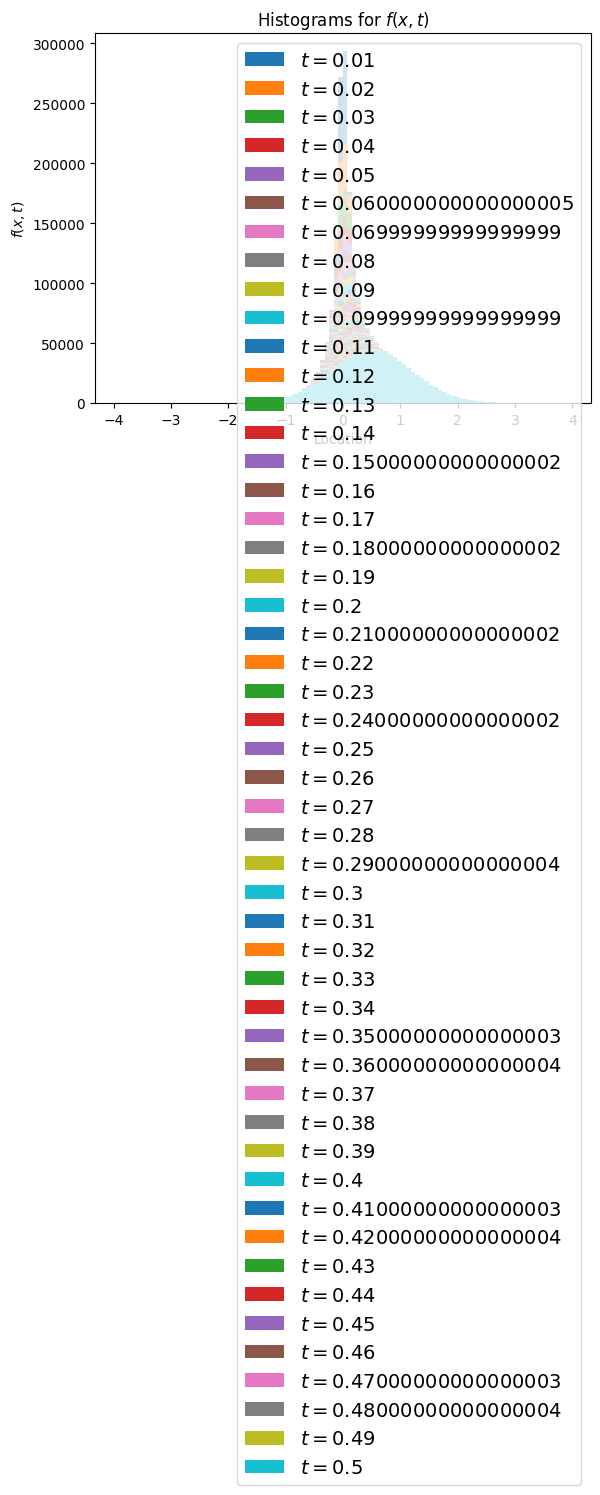

In [107]:
Ns = 10000
m = 50
n = 100
length = n*Ns
dt = 0.01
c = 1.

P = {}
M = 0

np.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length)) + c*dt*np.arange(length)

A_ex = c
D_ex = 0.5

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = np.linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = np.linspace(0,dt*(m-1),m)
U = np.zeros((n,m))
for i in range(m):
    U[:,i] = plt.hist(P[i],bins,label=r'$t = $' + str(i*dt+dt))[0]/float(dx*(len(pos)-m))

plt.xlabel('Location')
plt.ylabel(r'$f(x,t)$')
plt.title(r'Histograms for $f(x,t)$')
plt.legend(loc = 'upper right', fontsize = 14)

Nt = U.shape[1]
Nx = U.shape[0]
L = x[-1]-x[0]
fs = U.T

fs = np.array([fs])
dx = np.array([dx])
x = np.array([x])

fs0 = fs.copy()

Next, we denoise the data set using Singular Value Decomposition:

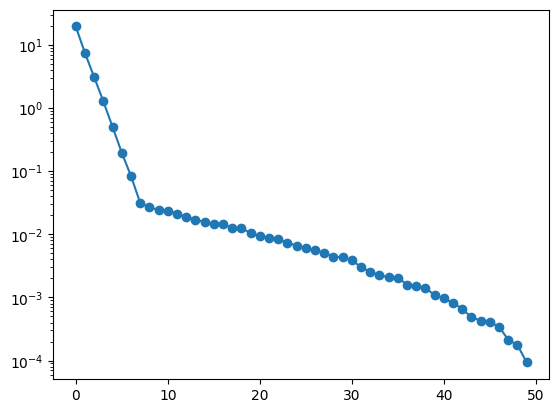

In [108]:
def condition(x): return x < thr

ufn,sigmafn,vfn = np.linalg.svd(fs[0,:,:].T, full_matrices=False); vfn = vfn.T

plt.figure()
plt.semilogy(sigmafn, marker="o")

thr = 1e-3

dim_f = [idx for idx, element in enumerate(abs(np.diff(sigmafn))) if condition(element)][0]

fd = ufn[:,0:dim_f].dot(np.diag(sigmafn[0:dim_f]).dot(vfn[:,0:dim_f].T))
fd = (fd.T)[None,:]

fd0 = fd.copy()

### Discover PDE using adjoint method

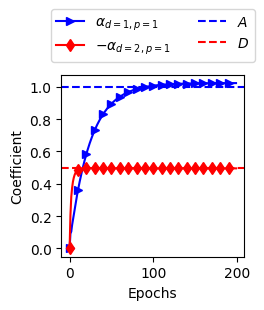

Execution time: 5.43969988822937
1.0215799535306191
total number of terms: 3


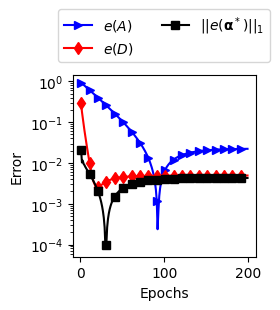

In [109]:
fd = fd0.copy()

ds = np.array([[1], [2], [3]])
ps = np.array([[1]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fd, dx, data_dt=dt, avg=True, gamma=1e-3, epochs=200, epthr=200, beta = 0.05, ds=ds, ps=ps, V = L, tol = 1e-6)
end_time = time.time()

i_pde =0;
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker=">", markevery=10)
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(-estimated_params[:,i_pde,id,ip], label=r"$-α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="red", marker="d", markevery=10)
plt.axhline(A_ex,    color="blue", linestyle = "--", label=r"$A$")
plt.axhline(D_ex,    color="red", linestyle = "--", label=r"$D$")
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=10)
name = problem + "_" + "coeffconv"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (  (d[0]==1 and p[0]==1) or
                  (d[0]==2 and p[0]==1)    ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker=">", markevery=10, color="blue")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(-estimated_params[1:,i_pde,id,ip]-D_ex),
                     label=r"$e(D)$", marker="d", markevery=10, color="red")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=10, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=10)
name = problem + "_" + "coeff"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## compute error:
err = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            err += abs(estimated_params[-1,i_pde,id,ip]-A_ex)
        elif d[0]==2 and p[0]==1:
            err += abs(estimated_params[-1,i_pde,id,ip]-D_ex)
        else:
            err += abs(estimated_params[-1, i_pde, id, ip])
print(err)

print("total number of terms: "+str(len(ds)*len(ps)))


### Discover PDE using PDE-FIND

In [110]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))
uxxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3
    uxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0) / dx[0]**4

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))
uxxxx = uxxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 0, data_description = ['u'])
print(['1'] + description[1:])

#c = TrainSTRidge(X,ut,10**-6,2)
c = FoBaGreedy(X, ut,10)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( np.real(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )[:,0]

err = abs(coeff_pdefind[0]+A_ex)
err += abs(coeff_pdefind[1]+D_ex)
if len(coeff_pdefind)>2:
    err += abs(coeff_pdefind[2:])

print(err)

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}']
u_t = (-0.818434 +0.000000i)u_{x}
    + (0.496322 +0.000000i)u_{xx}
   
Execution time: 0.027567148208618164
1.1778880059719086


/Users/mohsensadr/Codes/DiscoverPDEAdjoint/PDE-FIND/PDE_FIND.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  w_added[list(F_trial)] = np.linalg.lstsq(X[:, list(F_trial)], y, rcond=None)[0]


## Sparsity in time

Consider the case that only a fraction of the measured data is available. Here, we test how the adjoint method and PDE-FIND compare in finding the true PDE of the heat equation.

### Revisit Heat Equation

#### Generate Data

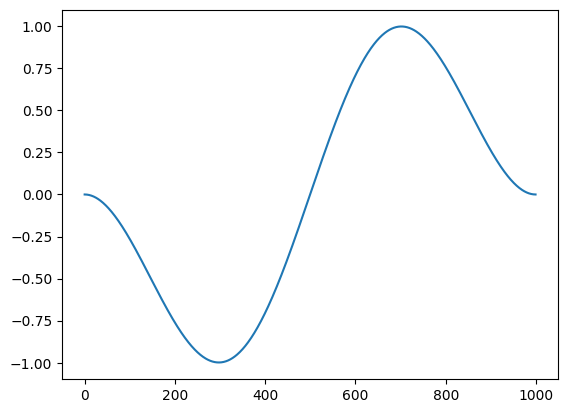

In [111]:
## generate data
# df/dt + D d2f/dx^2 = 0

CFL = 0.05
def dt_cfl(dx, D_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx**2/(1.+abs(D_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def heat_equation(D_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - D_m * np.gradient(np.gradient(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 1000  # Number of spatial grid points
D_ex = -1.0  # Thermal diffusivity

dx = L/Nx
dt = dt_cfl(dx, D_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = heat_equation(D_ex, f0, dx, dt, Nt)

alpha = 16
nsize = Nt/alpha
idx = [i for i in range(0,Nt,int(Nt/nsize))]
idx = np.sort(idx)
fs = fs[idx, :]

nt = np.diff(idx)+1
dts = [dt for _ in range(len(nt))]

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

plt.plot(fs[0,0,:])

#### Discover PDE using adjoint method

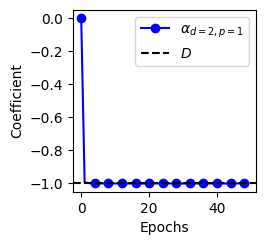

Execution time: 46.51514172554016
total number of terms: 18


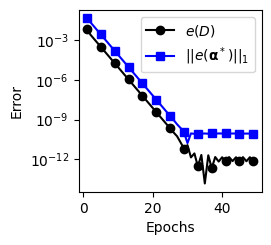

In [112]:
problem = "1D_heat_equation"
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, nt=nt, dt=dts, avg=False, gamma=1e-3, epochs=50, epthr=50, beta = 0.1, ds=ds, ps=ps, V = L, tol = 1e-15, eps0=1e-16)
end_time = time.time()

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==2 and p[0]==1 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Dconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()


print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==2 and p[0]==1 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1
            
## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),#/abs(D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "D"+str(nsize/Nt)
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

#### Discover PDE using PDE-FIND

In [113]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
ntt = len(nt)-1 #Nt-1

dt = dt*(nt[0]-1)
print(dt)

# Take up to second order derivatives.
u = np.zeros((ntt, Nx))
ut = np.zeros((ntt, Nx))
ux = np.zeros((ntt, Nx))
uxx = np.zeros((ntt, Nx))
uxxx = np.zeros((ntt, Nx))


for i in range(ntt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((ntt * Nx, 1))
ut = ut.reshape((ntt * Nx, 1))
ux = ux.reshape((ntt * Nx, 1))
uxx = uxx.reshape((ntt * Nx, 1))
uxxx = uxxx.reshape((ntt * Nx, 1))

num_points = ntt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-5,0.1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))


4e-07
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (0.999735 +0.000000i)u_{xx}
    + (-2.769027 +0.000000i)u
    + (4.051878 +0.000000i)u^3
    + (1.398126 +0.000000i)uu_{x}
    + (0.185073 +0.000000i)u^3u_{x}
    + (0.055569 +0.000000i)u^2u_{xx}
    + (0.016480 +0.000000i)uu_{xxx}
    + (0.002534 +0.000000i)u^3u_{xxx}
   
Execution time: 8.507201671600342


### Revisit Burgers' equation

#### Generate Data

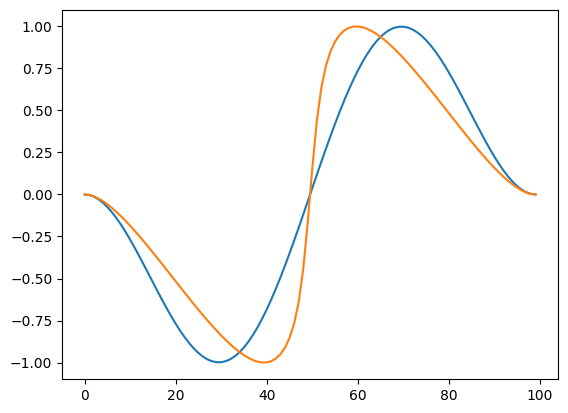

In [114]:
## generate data
# df/dt + A*f*df/dx = 0

CFL = 0.01
def dt_cfl(dx, A_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx/(1.+abs(A_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def burger_equation(A_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - np.gradient( A_m*f_m[i,:]**2)/dx_m * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient

dx = L/Nx
dt = dt_cfl(dx, A_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = burger_equation(A_ex, f0, dx, dt, Nt)


alpha = 16
nsize = Nt/alpha
idx = [i for i in range(0,Nt,int(Nt/nsize))]
idx = np.sort(idx)
fs = fs[idx, :]

nt = np.diff(idx)+1
dts = [dt for _ in range(len(nt))]

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

plt.plot(fs[0,0,:])
plt.plot(fs[0,-1,:])

#### Discover PDE using adjoint method

Execution time: 65.33126401901245


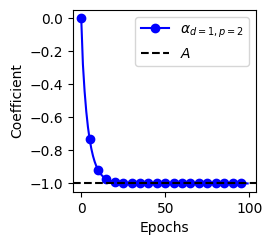

total number of terms: 18
4.431721527557838e-07


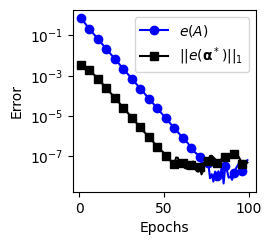

In [115]:
problem = "1D_burgers_eq_sparse"

fs = fs0.copy()

ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, nt=nt, dt=dts, avg=False, gamma=1e-3, epochs=100, epthr=100, beta = 0.00004, ds=ds, ps=ps, V = L, tol = 1e-15, eps0=1e-16)
end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==1 and p[0]==2 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue",marker="o", markevery=5)
            total_error = estimated_params[-1,i_pde,id,ip]
total_error = abs(total_error-A_ex)
plt.axhline(A_ex, color="black", linestyle = "--", label=r"$A$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "Aconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==1 and p[0]==2 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker="o", markevery=5, color="blue")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=5, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "A"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

total_error += err_other[-1]
print(total_error)


#### Discover PDE using PDE-FIND

In [116]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

fs = fs0.copy()
start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
ntt = len(nt)-1 #Nt-1

dt = dt*(nt[0]-1)
print(dt)

# Take up to second order derivatives.
u = np.zeros((ntt, Nx))
ut = np.zeros((ntt, Nx))
ux = np.zeros((ntt, Nx))
uxx = np.zeros((ntt, Nx))
uxxx = np.zeros((ntt, Nx))


for i in range(ntt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((ntt * Nx, 1))
ut = ut.reshape((ntt * Nx, 1))
ux = ux.reshape((ntt * Nx, 1))
uxx = uxx.reshape((ntt * Nx, 1))
uxxx = uxxx.reshape((ntt * Nx, 1))

num_points = ntt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-5,0.1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))


0.0008
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (0.086862 +0.000000i)u
    + (0.116872 +0.000000i)u^3
    + (2.021158 +0.000000i)uu_{x}
    + (0.005648 +0.000000i)u^2u_{xx}
    + (0.000074 +0.000000i)uu_{xxx}
   
Execution time: 0.6930291652679443


## Sensitivity to noise

### Revisit Heat Equation

#### Generate Noisy data for heat equation

In [117]:
## generate data, Heat
# df/dt + D d2f/dx^2 = 0

eps = 0.01 # noise in percentage
CFL = 0.05
def dt_cfl(dx, D_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx**2/(1.+abs(D_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def heat_equation(D_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - D_m * np.gradient(np.gradient(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
D_ex = -1.0  # Thermal diffusivity

dx = L/Nx
dt = dt_cfl(dx, D_ex)
Nt = 100
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = heat_equation(D_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

print(x.shape)
print(f0.shape)
print(fs.shape)


fs0 = fs.copy()

fn = fs + eps/100.*np.std(fs)*np.random.normal(0.,1, fs.shape)

(1, 100)
(1, 100)
(1, 100, 100)


#### Denoise Data using SVD

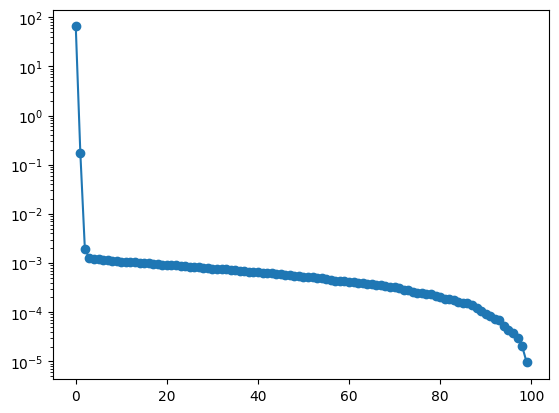

In [118]:
def condition(x): return x < thr

#uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
ufn,sigmafn,vfn = np.linalg.svd(fn[0,:,:].T, full_matrices=False); vfn = vfn.T

plt.figure()
plt.semilogy(sigmafn, marker="o")

thr = 1e-4

dim_f = [idx for idx, element in enumerate(abs(np.diff(sigmafn))) if condition(element)][0]

fd = ufn[:,0:dim_f].dot(np.diag(sigmafn[0:dim_f]).dot(vfn[:,0:dim_f].T))
fd = (fd.T)[None,:]


##### Adjoint for denoised data for heat equation

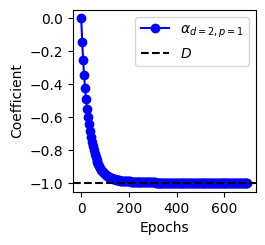

Execution time: 76.56187391281128
total number of terms: 18
8.534209576738228e-05


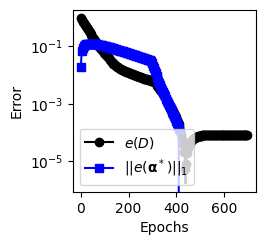

In [119]:
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fd, dx, data_dt=dt, avg=True, gamma=1e-3, epochs=1000, epthr=100, beta = 0.05, ds=ds, ps=ps, V = L, tol = 1e-10, eps0=1e-9)
end_time = time.time()

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==2 and p[0]==1 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
            err_D = estimated_params[-1,i_pde,id,ip]
err_D = abs(err_D - D_ex)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Dconv"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==2 and p[0]==1 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),#/abs(D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
#name = problem + "_" + "D"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))
print((err_other[-1])+err_D)


##### Using PDE-FIND

In [120]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fd[0, i, :]
    ut[i,:] = (fd[0, i+1, :]-fd[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,10)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(coeff_pdefind[0])
print(np.sum(coeff_pdefind[1:]) + abs(-coeff_pdefind[0]-D_ex))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (1.020101 +0.000000i)u_{xx}
    + (-18.700150 +0.000000i)u
    + (80.302027 +0.000000i)u^3
    + (7.264465 +0.000000i)uu_{x}
    + (-7.018686 +0.000000i)u^3u_{x}
    + (1.016071 +0.000000i)u^2u_{xx}
    + (0.073288 +0.000000i)uu_{xxx}
    + (-0.093372 +0.000000i)u^3u_{xxx}
   
Execution time: 1.0946869850158691
[1.02010149]
[114.48816032]


### Revisit Burgers' equation

#### Generate noisy data set

(1, 100)
(1, 100)
(1, 100, 100)


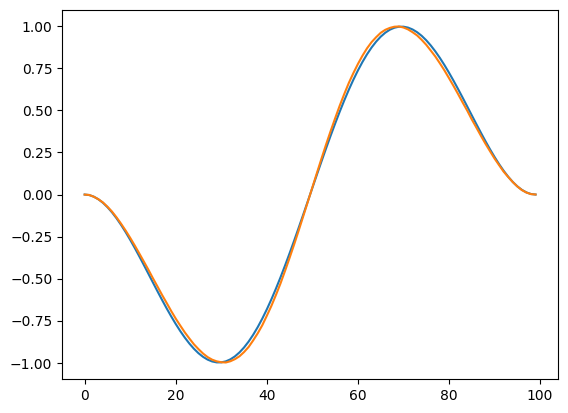

In [121]:
## generate data, burgers' equation
# df/dt + A*f*df/dx = 0

eps = 0.1 # noise in percentage

CFL = 0.01
def dt_cfl(dx, A_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx/(1.+abs(A_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def burger_equation(A_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - np.gradient( A_m*f_m[i,:]**2)/dx_m * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient

dx = L/Nx
dt = dt_cfl(dx, A_ex)
Nt = 100
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = burger_equation(A_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

print(x.shape)
print(f0.shape)
print(fs.shape)


fn = fs + eps/100.*np.std(fs)*np.random.normal(0.,1, fs.shape)

plt.plot(fs[0,0,:])
plt.plot(fn[0,-1,:])

#### Denoise data set

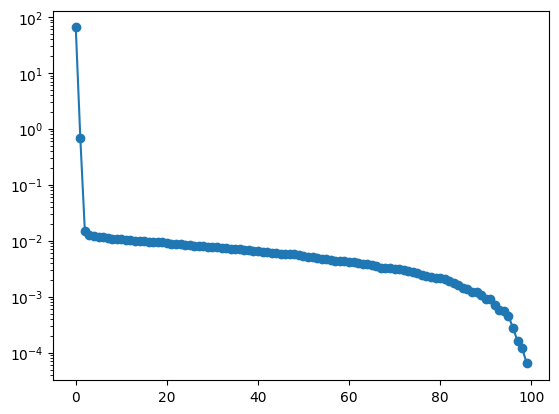

In [122]:
def condition(x): return x < thr

ufn,sigmafn,vfn = np.linalg.svd(fn[0,:,:].T, full_matrices=False); vfn = vfn.T

plt.figure()
plt.semilogy(sigmafn, marker="o")

thr = 1e-3

dim_f = [idx for idx, element in enumerate(abs(np.diff(sigmafn))) if condition(element)][0]

fd = ufn[:,0:dim_f].dot(np.diag(sigmafn[0:dim_f]).dot(vfn[:,0:dim_f].T))
fd = (fd.T)[None,:]


#### Find PDE using Adjoint method

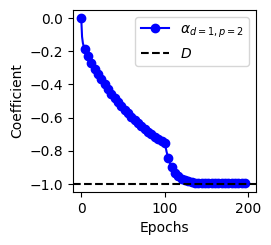

Execution time: 21.100581884384155
total number of terms: 18
0.0023730128364090053


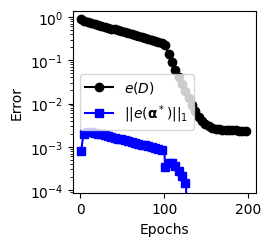

In [123]:
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fd, dx, data_dt=dt, avg=True, gamma=1e-3, epochs=200, epthr=100, beta = 0.005, ds=ds, ps=ps, V = L, tol = 1e-10, eps0=1e-16)
end_time = time.time()

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==1 and p[0]==2 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
            err_D = estimated_params[-1,i_pde,id,ip]
err_D = abs(err_D - D_ex)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Aconv"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==1 and p[0]==2 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),#/abs(D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
#name = problem + "_" + "D"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))
print((err_other[-1])+err_D)


#### Discover PDE using PDE-FIND

In [124]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fd[0, i, :]
    ut[i,:] = (fd[0, i+1, :]-fd[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,10)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(coeff_pdefind[0])
D_ex = 2
print("error: ", np.sum(coeff_pdefind[1:]) + abs(coeff_pdefind[0]-D_ex)[0])

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (2.001296 +0.000000i)uu_{x}
   
Execution time: 1.0586340427398682
[2.00129562]
error:  0.0012956242619734937


## Ill-posed problem

Consider a wave function $f(x,t)=\sin(x-t)$. This function is the solution to the following group of PDEs among other

$f_t + (k+1) f_x + k f_{xxx} + lf_{xx} + lf_{xxxx} = 0\ \ \ \ \forall l,k=0,1,...$.

If the considered family of PDEs in the dicovery task includes terms corresponding to more than one solution, the optimization problem is ill-posed.

To resolve this issue, we need to add another constraint into our optimization problem to distinguish the target PDE from all possible solutions. Here, we do this by simply finding the PDE that minimizes $||.||_2^2$ of coefficients. Therefore, the unique solution to this problem is

$f_t + f_x = 0$.

### Generate Data

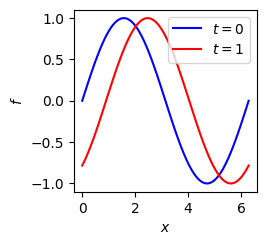

In [3]:
problem = "1D_ill-posed"

L = 2*np.pi
Nx = 100
Nt = 10
data_dt = 1e-1
dx = L/Nx

x =  np.linspace(0, L, Nx)
fs = np.zeros((1,Nt,Nx))

for it in range(Nt):
    fs[0,it,:] = np.sin(x-it*data_dt)

plt.figure(figsize=(size*cm, size*cm))
plt.plot(x, fs[0,0,:],color="blue", label=r"$t=0$")
plt.plot(x, fs[0,-1,:],color="red", label=r"$t=1$")
plt.ylabel(r'$f$')
plt.xlabel(r'$x$')
plt.legend()
plt.savefig(problem+"_data.pdf",format='pdf', bbox_inches="tight", dpi=300)

dx = np.array([dx])
x = np.array([x])

### Discover PDE using Adjoint method

Execution time: 418.3016822338104


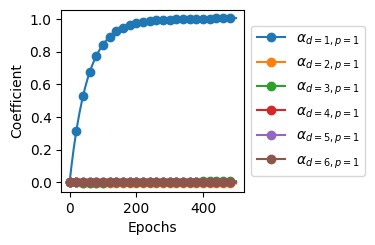

array([[[ 1.00499125e+00],
        [-7.32578539e-03],
        [ 6.84025426e-03],
        [-8.31675769e-04],
        [-1.34441422e-05],
        [-4.45039932e-06]]])

In [12]:
ps=np.array([[1]])
ds=np.array([[1], [2], [3], [4], [5], [6]])

start_time = time.time()
estimated_params, eps = AdjointFindPDE(fs, dx, data_dt, Nt_fine=100, avg=True, gamma=1e-2, epochs=500, epthr=499, beta = 0.0000002, ds=ds, ps=ps, V = L, tol = 1e-12, eps0=1e-12)
end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", marker="o", markevery=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

estimated_params[-1,:]


### Discover PDE using PDE-FIND

In [127]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

dt = data_dt

import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))
uxxxx = np.zeros((nt, Nx))
uxxxxx = np.zeros((nt, Nx))
uxxxxxx = np.zeros((nt, Nx))


for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3
    uxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0) / dx[0]**4
    uxxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0), axis=0) / dx[0]**5
    uxxxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0), axis=0), axis=0) / dx[0]**6

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))
uxxxx = uxxxx.reshape((nt * Nx, 1))
uxxxxx = uxxxxx.reshape((nt * Nx, 1))
uxxxxxx = uxxxxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx, uxxxx, uxxxxx, uxxxxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'u_{xxxxx}', 'u_{xxxxxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 1, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-9,1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(coeff_pdefind[0])
print(np.sum(coeff_pdefind[1:]) + abs(coeff_pdefind[0]-1.))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'u_{xxxxx}', 'u_{xxxxxx}', 'u', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'uu_{xxxx}', 'uu_{xxxxx}', 'uu_{xxxxxx}']
u_t = (-0.989758 +0.000000i)u_{x}
   
Execution time: 0.08303117752075195
[0.98975839]
[0.01024161]
